In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import skewnorm
# from ll_xy import lonlat_to_xy
from scipy.stats import linregress
import datetime
import string
import cartopy
# from tools import *
import cartopy.crs as ccrs
import pandas as pd
import scipy
from scipy.stats import skewnorm
from scipy.stats import lognorm
import pickle
import h5py
import sys
import xarray as xr
import os
from msc_thesis_functions import *
del sys.modules['msc_thesis_functions']
from msc_thesis_functions import *
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)

pd.set_option("mode.chained_assignment", None)

# dep_l = pickle.load(open('../pickles/line_depths_dict.p','rb'))
# statistics = pickle.load(open('../pickles/statistics.p','rb'))

# paths = pickle.load(open('../pickles/valid_nloops.p','rb'))

import matplotlib.font_manager as font_manager

font_path= '/Users/torka/Library/Fonts/FiraSans-Light.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()


dates = []

In [2]:
sites = [2,3,4,'grid3','grid4','grid5','grid6','grid7','grid8']

paths_MP = [
    # '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/CryoVEx2014_SEAICE_GROUNDDATA_V1/NORD_CAMP_TRANSECT.csv', #CRYOVEX 2014
    '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/ECCCEureka2014.h5', #EUREKA 2014
    '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/ECCC_2016_Eureka_Magnaprobe.csv' #EUREKA 2016
]

for year, path_MP in zip(['2014', '2016'], paths_MP):
    # load magnaprobe in situ data

    filetype = path_MP.split('.')[1]
    df_dict = open_data(path_MP, filetype=filetype, mode='dict', instrument='MP')

    if year == '2014':
        f = h5py.File(path_MP, 'r')
        group = f['eureka_data']
        data = group['magnaprobe']
        df_df = pd.DataFrame({'lat':data['latitude'][()], 'lon':data['longitude'][()], 'snow_depth':data['snow_depth'][()], 'site_id':data['site_id'][()]})
        df_df.loc[df_df['lon'] < 0, 'lon'] += 360
        df_df['ice_type'] = ['fyi']*len(df_df)
        df_df = df_df.loc[(df_df['site_id'] == 2) | (df_df['site_id'] == 3) | (df_df['site_id'] == 4)] 
        df_df.reset_index(drop=True, inplace=True)
        
    elif year == '2016':
        for key in ['grid3','grid4', 'grid5','grid6','grid7','grid8']:
            if not df_df.empty:
                df_df = pd.concat([df_df, df_dict[key]])
                
    df_df['x'], df_df['y'] = transformer.transform(df_df['lon'], df_df['lat'])

    sites = df_df['site_id'].unique()


path_to_outlines = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/grid_extents_v3'
files = os.listdir(path_to_outlines) 
files = np.sort([f for f in files if f.endswith('.shp')])
shape_dict = {}
for f, site in zip(files,sites):
    shape_dict[site] = gpd.read_file(path_to_outlines + '/' + f)


path_to_data = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v5_exactTrue/'
files = os.listdir(path_to_data) 
files = np.sort([f for f in files if f.endswith('.nc')])
kriging_dict = {}
for f,site in zip(files,sites):
    print(f)
    kriging_dict[site] = xr.open_dataset(os.path.join(path_to_data,f))  
    kriging_dict[site] = kriging_dict[site].rio.set_spatial_dims(x_dim='easting', y_dim='northing')
    
    
#opening ATM grids
path_ATM= '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v7'
files = os.listdir(path_ATM)
ATM_data_dict = {}
print('Opening ATM data:')
for site in sites:
    file = [x for x in files if x.split('_')[-1].split('.')[0] == str(site)][0]
    print(f'{site}: {file}')
    ds = xr.open_dataset(os.path.join(path_ATM, file))
    ATM_data_dict[site] = ds
print('------------------')


EUREKA2014_2_krigged_MP_snow_depth.nc
EUREKA2014_3_krigged_MP_snow_depth.nc
EUREKA2014_4_krigged_MP_snow_depth.nc
EUREKA2016_grid3_krigged_MP_snow_depth.nc
EUREKA2016_grid4_krigged_MP_snow_depth.nc
EUREKA2016_grid5_krigged_MP_snow_depth.nc
EUREKA2016_grid6_krigged_MP_snow_depth.nc
EUREKA2016_grid7_krigged_MP_snow_depth.nc
EUREKA2016_grid8_krigged_MP_snow_depth.nc
Opening ATM data:
2: EUREKA2014_ATM_gridded_2.nc
3: EUREKA2014_ATM_gridded_3.nc
4: EUREKA2014_ATM_gridded_4.nc
grid3: EUREKA2016_ATM_gridded_grid3.nc
grid4: EUREKA2016_ATM_gridded_grid4.nc
grid5: EUREKA2016_ATM_gridded_grid5.nc
grid6: EUREKA2016_ATM_gridded_grid6.nc
grid7: EUREKA2016_ATM_gridded_grid7.nc
grid8: EUREKA2016_ATM_gridded_grid8.nc
------------------


In [3]:
# import the robbie stuff

def compare_magna(df, statistics, ax=None, impose_y = False, anno=False, plot=True, skipper=1, bw=5):
     
    bin_edges = np.arange(0, 1, bw)


    mean_magna = np.nanmean(df['snow_depth'])

    ##################################################

    bc, ft = depth_distribution_from_depth(mean_magna, bin_edges, statistics=statistics)

    hist, bin_edges = np.histogram(np.array(df['snow_depth'])[::skipper],bins=bin_edges, density=True)
    
    rmse = np.round(np.sqrt(np.mean(np.square(ft-(hist*bw)))),decimals=3)
    
    if ax == None: fig, ax  = plt.subplots(1,1)
        
        
    # if anno:
    #     dt = datetime.datetime.strptime(df['Timestamp'][0],"%d/%m/%Y %H:%M")
        
    #     dates.append(dt)
    
    #     month = dt.date().month; day = dt.date().day
    #     site = df.loc[0, 'Site']
    #     ice_type = df.loc[0, 'IceType']
    #     ax.annotate(f'{site} ({ice_type})\n{day}/{month}',xy=(0.95,0.95),ha='right',va='top',xycoords='axes fraction')

    if plot:
        ax.step([0]+list(bc+bw/2),[0]+list(ft),color='r',)
        ax.step([0]+list(bc+bw/2), [0]+list(hist*bw),color='b')
        
        alpha=0.5
        
        t = ax.bar(bc, hist*bw,
                width=bw,
                alpha=alpha,
                color='#1f77b4',
                label='Values')

        m = ax.bar(bc, ft,
                width=bw,
                alpha=alpha,
                color='r',
                label='Site-wise model')
    
    ax.legend(loc='upper right')
    
    return(bc, hist*bw, ft, rmse)


def get_std_from_mean(mean_depth, grad):
    std = mean_depth * grad
    return (std)


def depth_distribution_from_depth(mean_depth, dep_bin_edges, statistics):
    dep_bin_centres = dep_bin_edges[:-1] + (dep_bin_edges[1] - dep_bin_edges[0]) / 2

    std = get_std_from_mean(mean_depth, statistics['stats'])

    std_bin_edges = (dep_bin_edges - mean_depth) / std
    std_bin_centres = std_bin_edges[:-1] + (std_bin_edges[1] - std_bin_edges[0]) / 2
    std_bw = np.nanmean(np.diff(std_bin_edges))

    fit = skewnorm.pdf(std_bin_centres,
                       statistics['a'],
                       statistics['loc'],
                       statistics['scale']) * std_bw

    return (dep_bin_centres, fit)


# path_to_pickles = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions'
# statistics = {}
# for site in sites[3:]:
#     statistics[site] = {}
#     statistics[site]['lognorm'] = pickle.load(open(os.path.join(path_to_pickles, f'statistics_lognorm_{site}.p'), 'rb'))
#     statistics[site]['skewnorm'] = pickle.load(open(os.path.join(path_to_pickles, f'statistics_lognorm_{site}.p'), 'rb'))
    

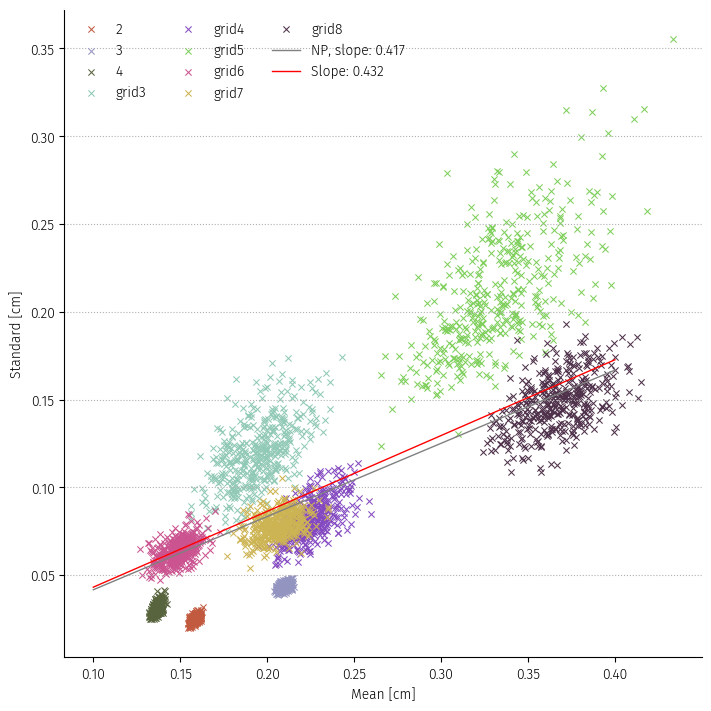

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), constrained_layout=True) 
# ax = ax.flatten()
cv = []
roughness = []
elevation = []
elevation2 = []
elevation3 = []
slope = []
c = []
n = 1200  # specify the number of random indices you want
n2 = 400

colors =  ["#c25a40", "#9494c1", "#58643d","#90c9b5", "#8449c1", "#7ecf5b", "#ca5390", "#cdb453", "#4e304a"]
list1_mean = []
list1_sd = []

list2_mean = []
list2_sd = []

for i, site in enumerate(sites):
    
    # df_f = df.loc[df['Site'] == site]
    df_f = kriging_dict[site].to_dataframe()
    df_f.reset_index(inplace=True)
    
    df_ATM = ATM_data_dict[site].to_dataframe()
    df_ATM.reset_index(inplace=True)
    
    for j in range(n2):
        inds = np.random.choice(df_f.index, size=n, replace=False)
        
        ax.scatter(np.nanmean(df_f.loc[inds, 'snow_depth']), np.nanstd(df_f.loc[inds, 'snow_depth']),
                   s=20,
                   marker='x',
                   color=colors[i],
                   label = site if j == 0 else '',
                   linewidths=.75
                   )
        cv.append(np.nanstd(df_f.loc[inds, 'snow_depth']) / np.nanmean(df_f.loc[inds, 'snow_depth']))
        roughness.append(np.nanmean(df_ATM.loc[inds, 'roughness']))
        slope.append(np.nanmean(df_ATM.loc[inds, 'slope']))
        
        elevation.append(np.nanmean(df_ATM.loc[inds, 'elevation']))
        elevation2.append(np.nanmedian(df_ATM.loc[inds, 'elevation']))
        elevation3.append(scipy.stats.mode(df_ATM.loc[inds, 'elevation']))
        
        
        c.append(colors[i])

        list1_mean.append(np.mean(df_f.loc[inds, 'snow_depth']))
        list1_sd.append(np.std(df_f.loc[inds, 'snow_depth']))

x = np.linspace(.1,.4,100)        
ax.plot(x, x*0.417, color='grey', lw=1, label='NP, slope: 0.417')

linr1 = linregress(list1_mean, list1_sd)
slope, intercept, r_value, p_value, std_err = linregress(list1_mean, list1_sd)
slope_forced = np.sum(np.array(list1_mean) * np.array(list1_sd)) / np.sum(np.array(list1_mean)**2)

ax.plot(x, slope_forced * x,
    color='red',
    ls='-',
    lw=1,
    label=f'Slope: {slope_forced:.3f}'
    )

ax.set_xlabel('Mean [cm]')
ax.set_ylabel('Standard [cm]')

ax.legend(loc='upper left',
          ncols=3,
          frameon=False
          )

ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.grid(ls=':', axis='y')

# ax.set_title(f'Coefficient of variation for EUREKA2016 sites\n{n2} x {n} random samples per site\nOLS lines not forced through origin',
#              ha='left',
#              x=0
#              )

### estimate site-wise distributions

/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6471: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6471: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6471: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


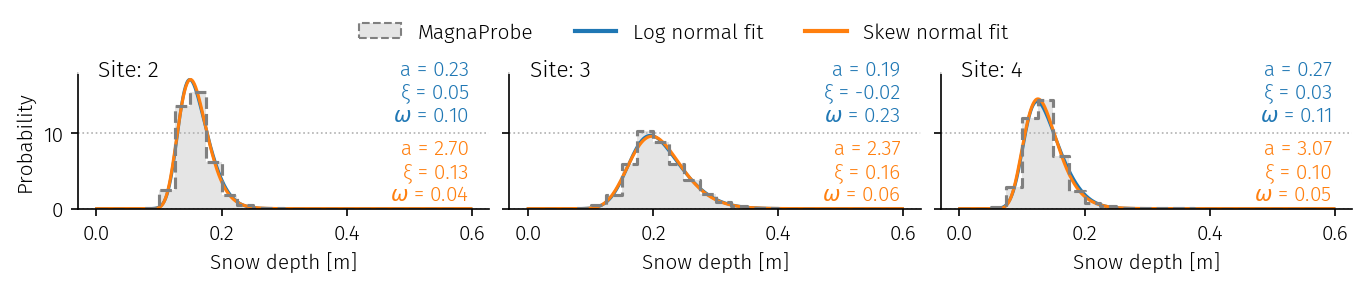

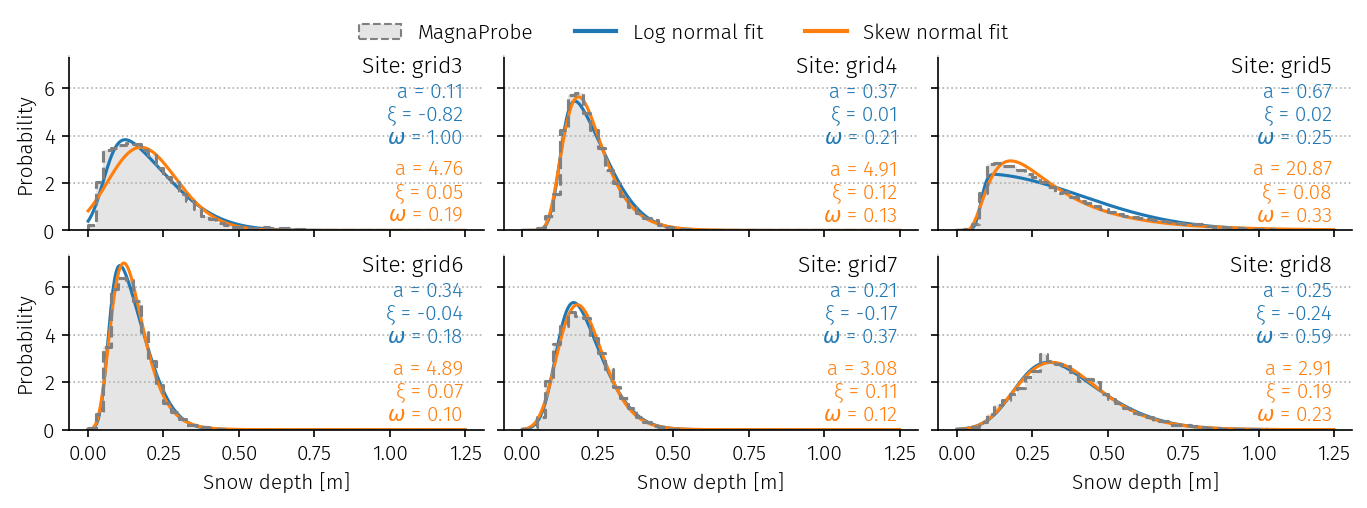

In [118]:

bw = 0.1/100
bw2 = 0.025
sites_2014 = [2,3,4]
fig, ax = plt.subplots(1,3,figsize=(9,1.5), sharex=True, sharey=True, constrained_layout=True, dpi=150)   
ax = ax.ravel()
ax[0].set_ylabel('Probability')

for i, site in enumerate(sites_2014):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_xlabel('Snow depth [m]')
    
    df_f = kriging_dict[site].to_dataframe()
    df_f.dropna(inplace=True)
    df_f.reset_index(inplace=True)
    f = skewnorm.fit(df_f['snow_depth'])
    f2 = lognorm.fit(df_f['snow_depth'])
    
    bin_edges = np.arange(0,0.6,bw)
    bin_edges2 = np.arange(0,0.6,bw2)
    
    bcs = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
    bcs2 = bin_edges2[:-1] + (bin_edges2[1] - bin_edges2[0]) / 2
    
    obs_fit = skewnorm.pdf(bcs,f[0],f[1],f[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)
    obs_fit2 = lognorm.pdf(bcs,f2[0],f2[1],f2[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)
    skewness = skew(df_f['snow_depth'])
    
    # hist, _ = np.histogram(df_f['snow_depth'], bins=bin_edges, density=True)
    
    ax[i].plot(bcs,obs_fit,color='C0', label=f'Skewnorm fit')
    ax[i].plot(bcs,obs_fit2,color='C1', label=f'Lognorm fit')
    
    # ax[i].step(bcs, hist, width=bw, alpha=0.5, color='grey')
    
    # ax[i].bar(bcs, hist, width=bw, color='grey', label='Raw histogram', alpha=.2)
    
    
    hist, bin_edges2 = np.histogram(df_f['snow_depth'], bins=bin_edges2, density=True)
    ax[i].step([0]+list(bcs2+bw2/2), [0]+list(hist),color='grey', ls='--')
    t = ax[i].bar(bcs2, hist,
                width=bw2,
                alpha=.2,
                color='grey'
                )
    
    
    ax[i].text(0.05, 1.1, f'Site: {site}', transform=ax[i].transAxes, ha='left', va='top', size=11)
    
    #Save the fitted models
    a = f2[0]
    loc = f2[1]
    scale  = f2[2]

    stats = slope_forced
        
    n = len(df_f)

    statistics_log = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
    with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_lognorm_{site}.p', 'wb') as file:
        pickle.dump(statistics_log, file)
        
    ax[i].text(0.95, 1.1, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='C0')

    a = f[0]
    loc = f[1]
    scale  = f[2]

    stats = slope_forced
        
    n = len(df_f)

    statistics_skew = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
    with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_skewnorm_{site}.p', 'wb') as file:
        pickle.dump(statistics_skew, file)
        
    ax[i].text(0.95, 0.03, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[i].transAxes, ha='right', va='bottom', color='C1')

legend_elements = [Patch(facecolor=mcolors.to_rgba('grey', alpha=.2), edgecolor='grey', label='MagnaProbe', linestyle='--'),
                  Line2D([0], [0], color='C0', lw=2, label='Log normal fit'),
                  Line2D([0], [0], color='C1', lw=2, label='Skew normal fit'),
                   ]

fig.legend(handles=legend_elements, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.22), frameon=False)
  

bw = 0.1/100
bw2 = 0.025
sites_2016 = ['grid3','grid4','grid5','grid6','grid7','grid8']
fig, ax = plt.subplots(2,3,figsize=(9,3), sharex=True, sharey=True, constrained_layout=True, dpi=150)   
ax = ax.ravel()
ax[0].set_ylabel('Probability')
ax[3].set_ylabel('Probability')
ax[3].set_xlabel('Snow depth [m]')
ax[4].set_xlabel('Snow depth [m]')
ax[5].set_xlabel('Snow depth [m]')

for i, site in enumerate(sites_2016):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    
    df_f = kriging_dict[site].to_dataframe()
    df_f.dropna(inplace=True)
    df_f.reset_index(inplace=True)
    f = skewnorm.fit(df_f['snow_depth'])
    f2 = lognorm.fit(df_f['snow_depth'])
    
    bin_edges = np.arange(0,1.25,bw)
    bin_edges2 = np.arange(0,1.25,bw2)
    
    bcs = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
    bcs2 = bin_edges2[:-1] + (bin_edges2[1] - bin_edges2[0]) / 2
    
    obs_fit = skewnorm.pdf(bcs,f[0],f[1],f[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)
    obs_fit2 = lognorm.pdf(bcs,f2[0],f2[1],f2[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)
    skewness = skew(df_f['snow_depth'])
    
    # hist, _ = np.histogram(df_f['snow_depth'], bins=bin_edges, density=True)
    
    ax[i].plot(bcs,obs_fit,color='C0')
    ax[i].plot(bcs,obs_fit2,color='C1')
    
    # ax[i].step(bcs, hist, width=bw, alpha=0.5, color='grey')
    
    # ax[i].bar(bcs, hist, width=bw, color='grey', label='Raw histogram', alpha=.2)
    
    
    hist, bin_edges2 = np.histogram(df_f['snow_depth'], bins=bin_edges2, density=True)
    ax[i].step([0]+list(bcs2+bw2/2), [0]+list(hist),color='grey', ls='--')
    t = ax[i].bar(bcs2, hist,
                width=bw2,
                alpha=.2,
                color='grey'
                )
    
    ax[i].text(0.95, 1, f'Site: {site}', transform=ax[i].transAxes, ha='right', va='top', size=11)
    

    
    
    #Save the fitted models
    a = f2[0]
    loc = f2[1]
    scale  = f2[2]

    stats = slope_forced
        
    n = len(df_f)

    statistics_log = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
    with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_lognorm_{site}.p', 'wb') as file:
        pickle.dump(statistics_log, file)
        
    ax[i].text(0.95, 0.85, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='C0')

    a = f[0]
    loc = f[1]
    scale  = f[2]

    stats = slope_forced
        
    n = len(df_f)

    statistics_skew = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
    with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_skewnorm_{site}.p', 'wb') as file:
        pickle.dump(statistics_skew, file)
        
    ax[i].text(0.95, 0.03, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[i].transAxes, ha='right', va='bottom', color='C1')

legend_elements = [Patch(facecolor=mcolors.to_rgba('grey', alpha=.2), edgecolor='grey', label='MagnaProbe', linestyle='--'),
                  Line2D([0], [0], color='C0', lw=2, label='Log normal fit'),
                  Line2D([0], [0], color='C1', lw=2, label='Skew normal fit'),
                   ]

fig.legend(handles=legend_elements, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False)

### ICE-AGE and ICE-TYPE (DEFORMATION) WISE DISTRIBUTIONS

/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6471: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


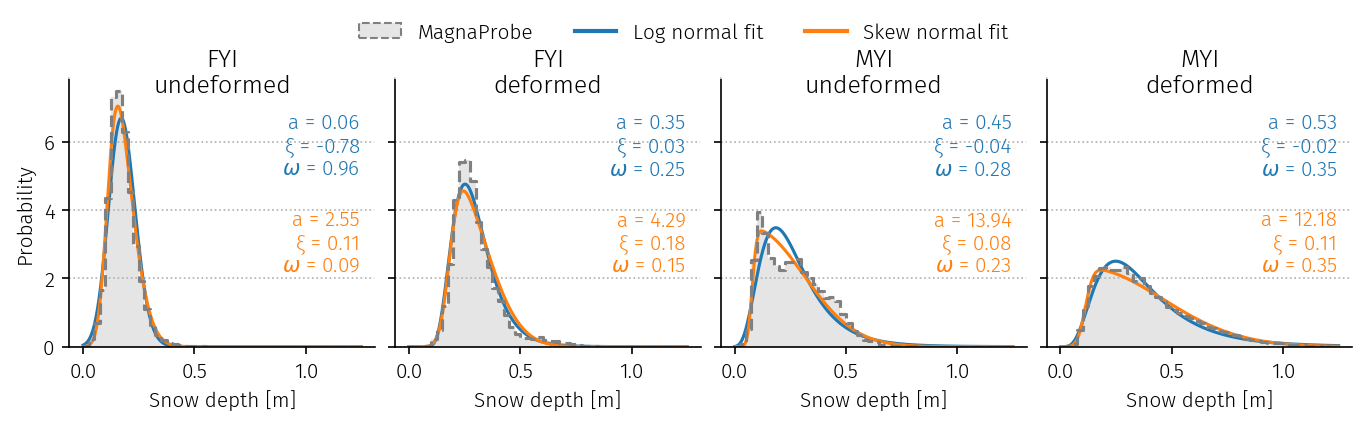

In [16]:

fyi_undeformed_snow_depths = []
fyi_deformed_snow_depths = []

myi_undeformed_snow_depths = []
myi_deformed_snow_depths = []

bw = 0.1/100
bw2 = 0.025
fig, ax = plt.subplots(1,4,figsize=(9,2.5), sharex=True, sharey=True, constrained_layout=True, dpi=150)   
ax = ax.ravel()
ax[0].set_ylabel('Probability') 

for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    
    ax[i].set_xlabel('Snow depth [m]')
    
for i, site in enumerate(sites):
    df = kriging_dict[site].to_dataframe()
    df.reset_index(inplace=True)
    
    if site == 'grid8' or site == 'grid5':
        mask = df['classes'] == 0
        myi_undeformed_snow_depths.append(df.loc[mask, 'snow_depth'].to_list())
        
        mask = df['classes'] == 1
        myi_deformed_snow_depths.append(df.loc[mask, 'snow_depth'].to_list())       
    else:
        mask = df['classes'] == 0
        fyi_undeformed_snow_depths.append(df.loc[mask, 'snow_depth'].to_list())
        
        mask = df['classes'] == 1
        fyi_deformed_snow_depths.append(df.loc[mask, 'snow_depth'].to_list())
    
fyi_undeformed_snow_depths = np.array([item for sublist in fyi_undeformed_snow_depths for item in sublist])
fyi_undeformed_snow_depths = fyi_undeformed_snow_depths[~np.isnan(fyi_undeformed_snow_depths)]

fyi_deformed_snow_depths = np.array([item for sublist in fyi_deformed_snow_depths for item in sublist])
fyi_deformed_snow_depths = fyi_deformed_snow_depths[~np.isnan(fyi_deformed_snow_depths)]

myi_undeformed_snow_depths = np.array([item for sublist in myi_undeformed_snow_depths for item in sublist])
myi_undeformed_snow_depths = myi_undeformed_snow_depths[~np.isnan(myi_undeformed_snow_depths)]

myi_deformed_snow_depths = np.array([item for sublist in myi_deformed_snow_depths for item in sublist])
myi_deformed_snow_depths = myi_deformed_snow_depths[~np.isnan(myi_deformed_snow_depths)]


f = skewnorm.fit(fyi_undeformed_snow_depths)
f2 = lognorm.fit(fyi_undeformed_snow_depths)

bin_edges = np.arange(0,1.25,bw)
bin_edges2 = np.arange(0,1.25,bw2)

bcs = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
bcs2 = bin_edges2[:-1] + (bin_edges2[1] - bin_edges2[0]) / 2

obs_fit = skewnorm.pdf(bcs,f[0],f[1],f[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)
obs_fit2 = lognorm.pdf(bcs,f2[0],f2[1],f2[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)

ax[0].plot(bcs,obs_fit2,color='C0')
ax[0].plot(bcs,obs_fit,color='C1')

hist, bin_edges2 = np.histogram(fyi_undeformed_snow_depths, bins=bin_edges2, density=True)
ax[0].step([0]+list(bcs2+bw2/2), [0]+list(hist),color='grey', ls='--')
t = ax[0].bar(bcs2, hist,
            width=bw2,
            alpha=.2,
            color='grey'
            )

#Save the fitted models
a = f2[0]
loc = f2[1]
scale  = f2[2]
stats = slope_forced
    
n = len(df_f)

statistics_log = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_lognorm_fyi_undeformed.p', 'wb') as file:
    pickle.dump(statistics_log, file)
    
ax[0].text(0.95, 0.87, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[0].transAxes, ha='right', va='top', color='C0')

a = f[0]
loc = f[1]
scale  = f[2]

stats = slope_forced
    
n = len(df_f)

statistics_skew = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_skewnorm_myi_deformed.p', 'wb') as file:
    pickle.dump(statistics_skew, file)
    
ax[0].text(0.95, 0.51, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[0].transAxes, ha='right', va='top', color='C1')

########
f = skewnorm.fit(fyi_deformed_snow_depths)
f2 = lognorm.fit(fyi_deformed_snow_depths)

bin_edges = np.arange(0,1.25,bw)
bin_edges2 = np.arange(0,1.25,bw2)

bcs = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
obs_fit = skewnorm.pdf(bcs,f[0],f[1],f[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)
obs_fit2 = lognorm.pdf(bcs,f2[0],f2[1],f2[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)


ax[1].plot(bcs,obs_fit2,color='C0')
ax[1].plot(bcs,obs_fit,color='C1')

hist, bin_edges2 = np.histogram(fyi_deformed_snow_depths, bins=bin_edges2, density=True)
ax[1].step([0]+list(bcs2+bw2/2), [0]+list(hist),color='grey', ls='--')
t = ax[1].bar(bcs2, hist,
            width=bw2,
            alpha=.2,
            color='grey'
            )
#Save the fitted models
a = f2[0]
loc = f2[1]
scale  = f2[2]

stats = slope_forced
    
n = len(df_f)

statistics_log = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_lognorm_fyi_deformed.p', 'wb') as file:
    pickle.dump(statistics_log, file)
    
ax[1].text(0.95, 0.87, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[1].transAxes, ha='right', va='top', color='C0')

a = f[0]
loc = f[1]
scale  = f[2]

stats = slope_forced
    
n = len(df_f)

statistics_skew = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_skewnorm_myi_deformed.p', 'wb') as file:
    pickle.dump(statistics_skew, file)
    
ax[1].text(0.95, 0.51, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[1].transAxes, ha='right', va='top', color='C1')

#########
f = skewnorm.fit(myi_undeformed_snow_depths)
f2 = lognorm.fit(myi_undeformed_snow_depths)

bin_edges = np.arange(0,1.25,bw)
bin_edges2 = np.arange(0,1.25,bw2)

bcs = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
obs_fit = skewnorm.pdf(bcs,f[0],f[1],f[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)
obs_fit2 = lognorm.pdf(bcs,f2[0],f2[1],f2[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)


ax[2].plot(bcs,obs_fit2,color='C0')
ax[2].plot(bcs,obs_fit,color='C1')


hist, bin_edges2 = np.histogram(myi_undeformed_snow_depths, bins=bin_edges2, density=True)
ax[2].step([0]+list(bcs2+bw2/2), [0]+list(hist),color='grey', ls='--')
t = ax[2].bar(bcs2, hist,
            width=bw2,
            alpha=.2,
            color='grey'
            )
#Save the fitted models
a = f2[0]
loc = f2[1]
scale  = f2[2]

stats = slope_forced
    
n = len(df_f)

statistics_log = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_lognorm_myi_undeformed.p', 'wb') as file:
    pickle.dump(statistics_log, file)
    
ax[2].text(0.95, 0.87, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[2].transAxes, ha='right', va='top', color='C0')

a = f[0]
loc = f[1]
scale  = f[2]

stats = slope_forced
    
n = len(df_f)

statistics_skew = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_skewnorm_myi_deformed.p', 'wb') as file:
    pickle.dump(statistics_skew, file)
    
ax[2].text(0.95, 0.51, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[2].transAxes, ha='right', va='top', color='C1')
#########
f = skewnorm.fit(myi_deformed_snow_depths)
f2 = lognorm.fit(myi_deformed_snow_depths)

bin_edges = np.arange(0,1.25,bw)
bin_edges2 = np.arange(0,1.25,bw2)

bcs = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
obs_fit = skewnorm.pdf(bcs,f[0],f[1],f[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)
obs_fit2 = lognorm.pdf(bcs,f2[0],f2[1],f2[2]) #a (skewness parameter), loc (location parameter), scale (scaling parameter)


ax[3].plot(bcs,obs_fit2,color='C0')
ax[3].plot(bcs,obs_fit,color='C1')


hist, bin_edges2 = np.histogram(myi_deformed_snow_depths, bins=bin_edges2, density=True)
ax[3].step([0]+list(bcs2+bw2/2), [0]+list(hist),color='grey', ls='--')
t = ax[3].bar(bcs2, hist,
            width=bw2,
            alpha=.2,
            color='grey'
            )
#Save the fitted models
a = f2[0]
loc = f2[1]
scale  = f2[2]

stats = slope_forced
    
n = len(df_f)

statistics_log = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_lognorm_myi_deformed.p', 'wb') as file:
    pickle.dump(statistics_log, file)
    
ax[3].text(0.95, 0.87, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[3].transAxes, ha='right', va='top', color='C0')

a = f[0]
loc = f[1]
scale  = f[2]

stats = slope_forced
    
n = len(df_f)

statistics_skew = {'a': a, 'loc': loc, 'scale': scale, 'stats': stats, 'n': n}
with open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_skewnorm_myi_deformed.p', 'wb') as file:
    pickle.dump(statistics_skew, file)
    
ax[3].text(0.95, 0.51, f'a = {a:.2f}\nξ = {loc:.2f}\n$\omega$ = {scale:.2f}', transform=ax[3].transAxes, ha='right', va='top', color='C1')

    
ax[0].set_title('FYI\nundeformed', y=.9)
ax[1].set_title('FYI\ndeformed', y=.9)
ax[2].set_title('MYI\nundeformed', y=.9)
ax[3].set_title('MYI\ndeformed', y=.9)

legend_elements = [Patch(facecolor=mcolors.to_rgba('grey', alpha=.2), edgecolor='grey', label='MagnaProbe', linestyle='--'),
                  Line2D([0], [0], color='C0', lw=2, label='Log normal fit'),
                  Line2D([0], [0], color='C1', lw=2, label='Skew normal fit'),
                   ]

fig.legend(handles=legend_elements, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False)